# Results Analysis Notebook

This notebook reproduces evaluation figures and sample comparisons for inclusion in research papers. It reads the generated analysis in `results_analysis/` and recreates publication-quality plots (confusion matrix, metric distributions, performance summary, WOA convergence) and displays sample outputs (original vs processed).

In [1]:
# 1) Import required libraries

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
import os
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['savefig.dpi'] = 300

DATA_DIR = Path('../results_analysis').resolve()
METRICS_DIR = DATA_DIR / 'metrics'
GRAPHS_DIR = DATA_DIR / 'graphs'
OUTPUTS_DIR = DATA_DIR / 'outputs'
NOTEBOOK_FIG_DIR = DATA_DIR / 'notebook_figures'
NOTEBOOK_FIG_DIR.mkdir(parents=True, exist_ok=True)

print('Results dir:', DATA_DIR)



Results dir: /Users/shreyatiwari/Documents/Soft Computing Project/results_analysis


In [2]:
# 2) Load metrics and per-sample results

metrics_json_path = METRICS_DIR / 'detailed_metrics.json'
csv_path = METRICS_DIR / 'per_sample_metrics.csv'

if metrics_json_path.exists():
    with open(metrics_json_path, 'r') as f:
        detailed = json.load(f)
    print('Loaded detailed metrics:', metrics_json_path)
else:
    detailed = None
    print('detailed_metrics.json not found in', METRICS_DIR)

if csv_path.exists():
    df = pd.read_csv(csv_path)
    print('Loaded per-sample CSV:', csv_path)
else:
    df = None
    print('per_sample_metrics.csv not found in', METRICS_DIR)

# Basic summary
if detailed is not None:
    print('\nSummary:')
    print('Test samples:', detailed.get('test_samples', 'N/A'))
    print('Threshold:', detailed.get('threshold', 'N/A'))
    print('Average metrics keys:', list(detailed.get('average_metrics', {}).keys()))



Loaded detailed metrics: /Users/shreyatiwari/Documents/Soft Computing Project/results_analysis/metrics/detailed_metrics.json
Loaded per-sample CSV: /Users/shreyatiwari/Documents/Soft Computing Project/results_analysis/metrics/per_sample_metrics.csv

Summary:
Test samples: 100
Threshold: 0.504
Average metrics keys: ['F1 Score', 'Precision', 'Recall', 'Accuracy', 'Specificity']


Saved confusion matrix figure to /Users/shreyatiwari/Documents/Soft Computing Project/results_analysis/notebook_figures/confusion_matrix_notebook.png


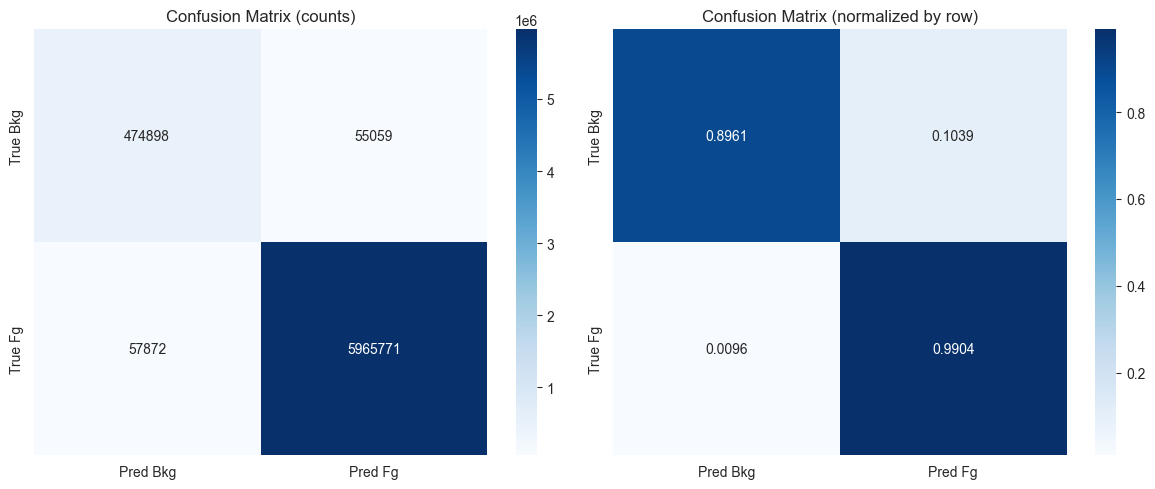

In [3]:
# 3) Confusion matrix (from aggregated counts) and plot

if detailed is not None and 'confusion_matrix' in detailed:
    cm = detailed['confusion_matrix']
    tn = cm.get('tn', 0)
    fp = cm.get('fp', 0)
    fn = cm.get('fn', 0)
    tp = cm.get('tp', 0)
    conf_mat = np.array([[tn, fp], [fn, tp]])
else:
    # Try to aggregate from per-sample CSV
    if df is not None and {'tp','fp','fn','tn'}.issubset(df.columns):
        tn = df['tn'].sum()
        fp = df['fp'].sum()
        fn = df['fn'].sum()
        tp = df['tp'].sum()
        conf_mat = np.array([[tn, fp], [fn, tp]])
    else:
        conf_mat = None

if conf_mat is not None:
    fig, axes = plt.subplots(1,2, figsize=(12,5))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=['Pred Bkg','Pred Fg'], yticklabels=['True Bkg','True Fg'])
    axes[0].set_title('Confusion Matrix (counts)')

    cm_norm = conf_mat.astype(float) / conf_mat.sum(axis=1)[:,None]
    sns.heatmap(cm_norm, annot=True, fmt='.4f', cmap='Blues', ax=axes[1],
                xticklabels=['Pred Bkg','Pred Fg'], yticklabels=['True Bkg','True Fg'])
    axes[1].set_title('Confusion Matrix (normalized by row)')

    plt.tight_layout()
    out_path = NOTEBOOK_FIG_DIR / 'confusion_matrix_notebook.png'
    fig.savefig(out_path, bbox_inches='tight')
    print('Saved confusion matrix figure to', out_path)
    plt.show()
else:
    print('Confusion matrix not available')


Saved metrics distribution to /Users/shreyatiwari/Documents/Soft Computing Project/results_analysis/notebook_figures/metrics_distribution_notebook.png


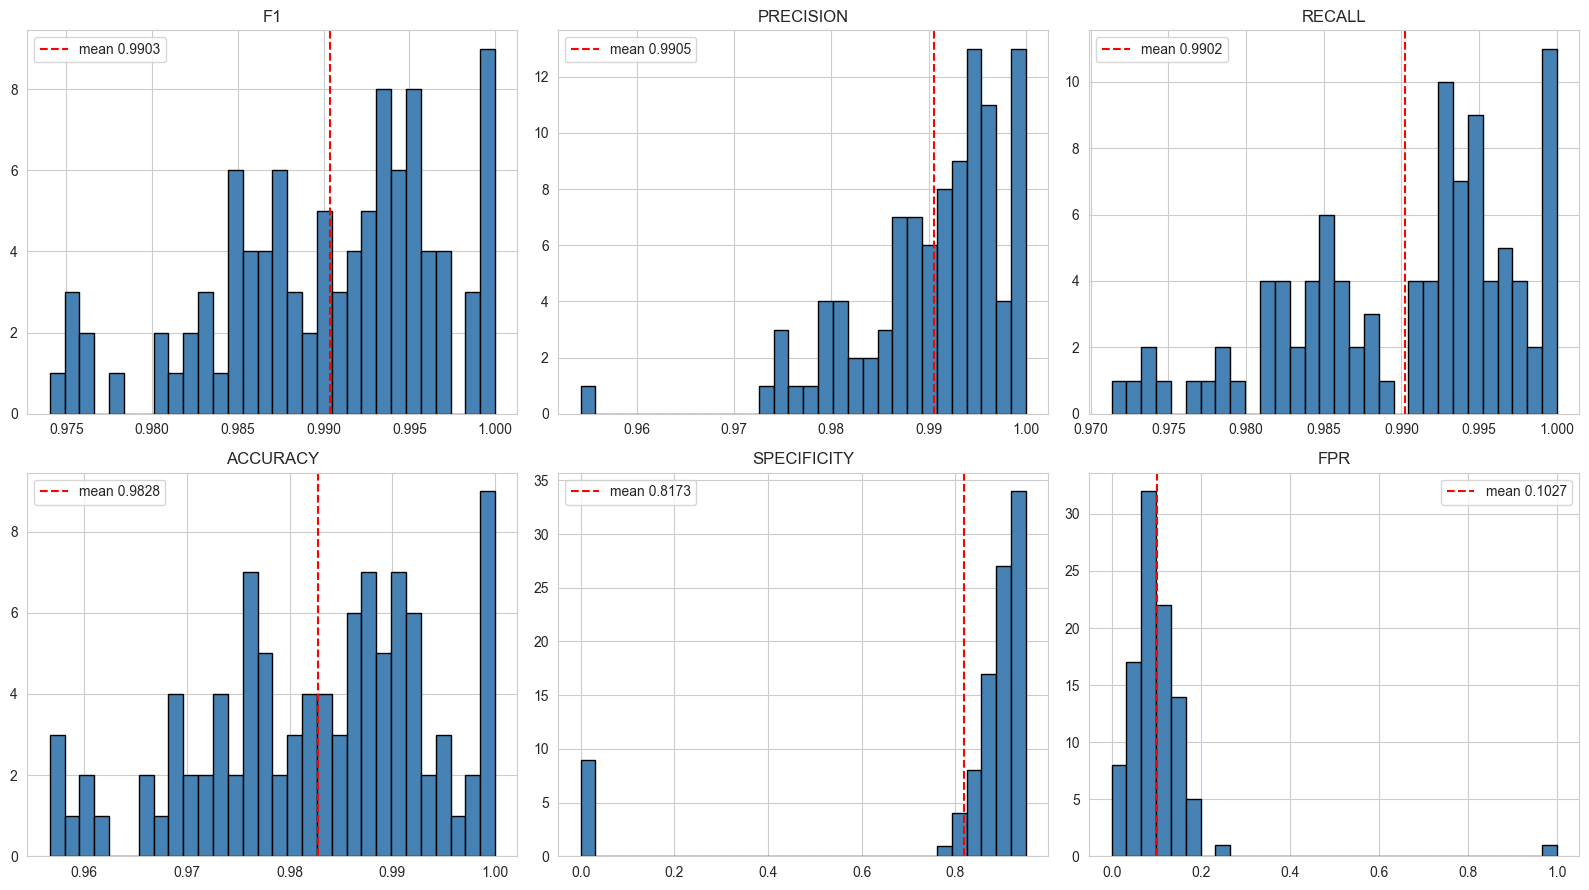

In [4]:
# 4) Metrics distribution plots

if df is not None:
    metrics_to_plot = ['f1','precision','recall','accuracy','specificity','fpr']
    fig, axes = plt.subplots(2,3, figsize=(16,9))
    axes = axes.flatten()
    for i, m in enumerate(metrics_to_plot):
        if m in df.columns:
            axes[i].hist(df[m].dropna(), bins=30, color='steelblue', edgecolor='black')
            axes[i].axvline(df[m].mean(), color='red', linestyle='--', label=f'mean {df[m].mean():.4f}')
            axes[i].set_title(m.upper())
            axes[i].legend()
        else:
            axes[i].text(0.5, 0.5, f'{m} not found', ha='center')
    plt.tight_layout()
    out_path = NOTEBOOK_FIG_DIR / 'metrics_distribution_notebook.png'
    fig.savefig(out_path, bbox_inches='tight')
    print('Saved metrics distribution to', out_path)
    plt.show()
else:
    print('Per-sample CSV not available; skipping distribution plots')


Saved performance summary to /Users/shreyatiwari/Documents/Soft Computing Project/results_analysis/notebook_figures/performance_summary_notebook.png


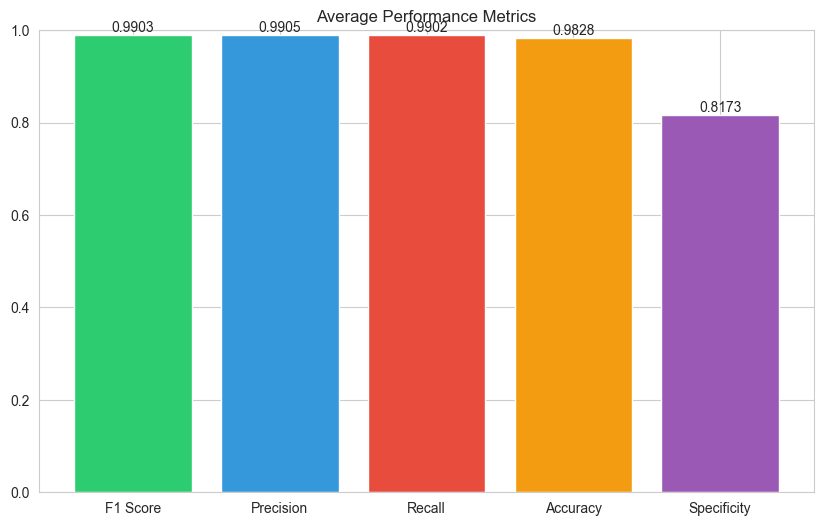

In [5]:
# 5) Performance summary bar chart (averages)

if detailed is not None and 'average_metrics' in detailed:
    avg = detailed['average_metrics']
    keys = ['F1 Score','Precision','Recall','Accuracy','Specificity']
    vals = [avg.get(k, np.nan) for k in keys]
    fig, ax = plt.subplots(figsize=(10,6))
    bars = ax.bar(keys, vals, color=['#2ecc71','#3498db','#e74c3c','#f39c12','#9b59b6'])
    for bar in bars:
        ax.text(bar.get_x()+bar.get_width()/2, bar.get_height(), f"{bar.get_height():.4f}", ha='center', va='bottom')
    ax.set_ylim(0,1)
    ax.set_title('Average Performance Metrics')
    out_path = NOTEBOOK_FIG_DIR / 'performance_summary_notebook.png'
    fig.savefig(out_path, bbox_inches='tight')
    print('Saved performance summary to', out_path)
    plt.show()
else:
    print('Average metrics not found in detailed json; skipping performance summary')


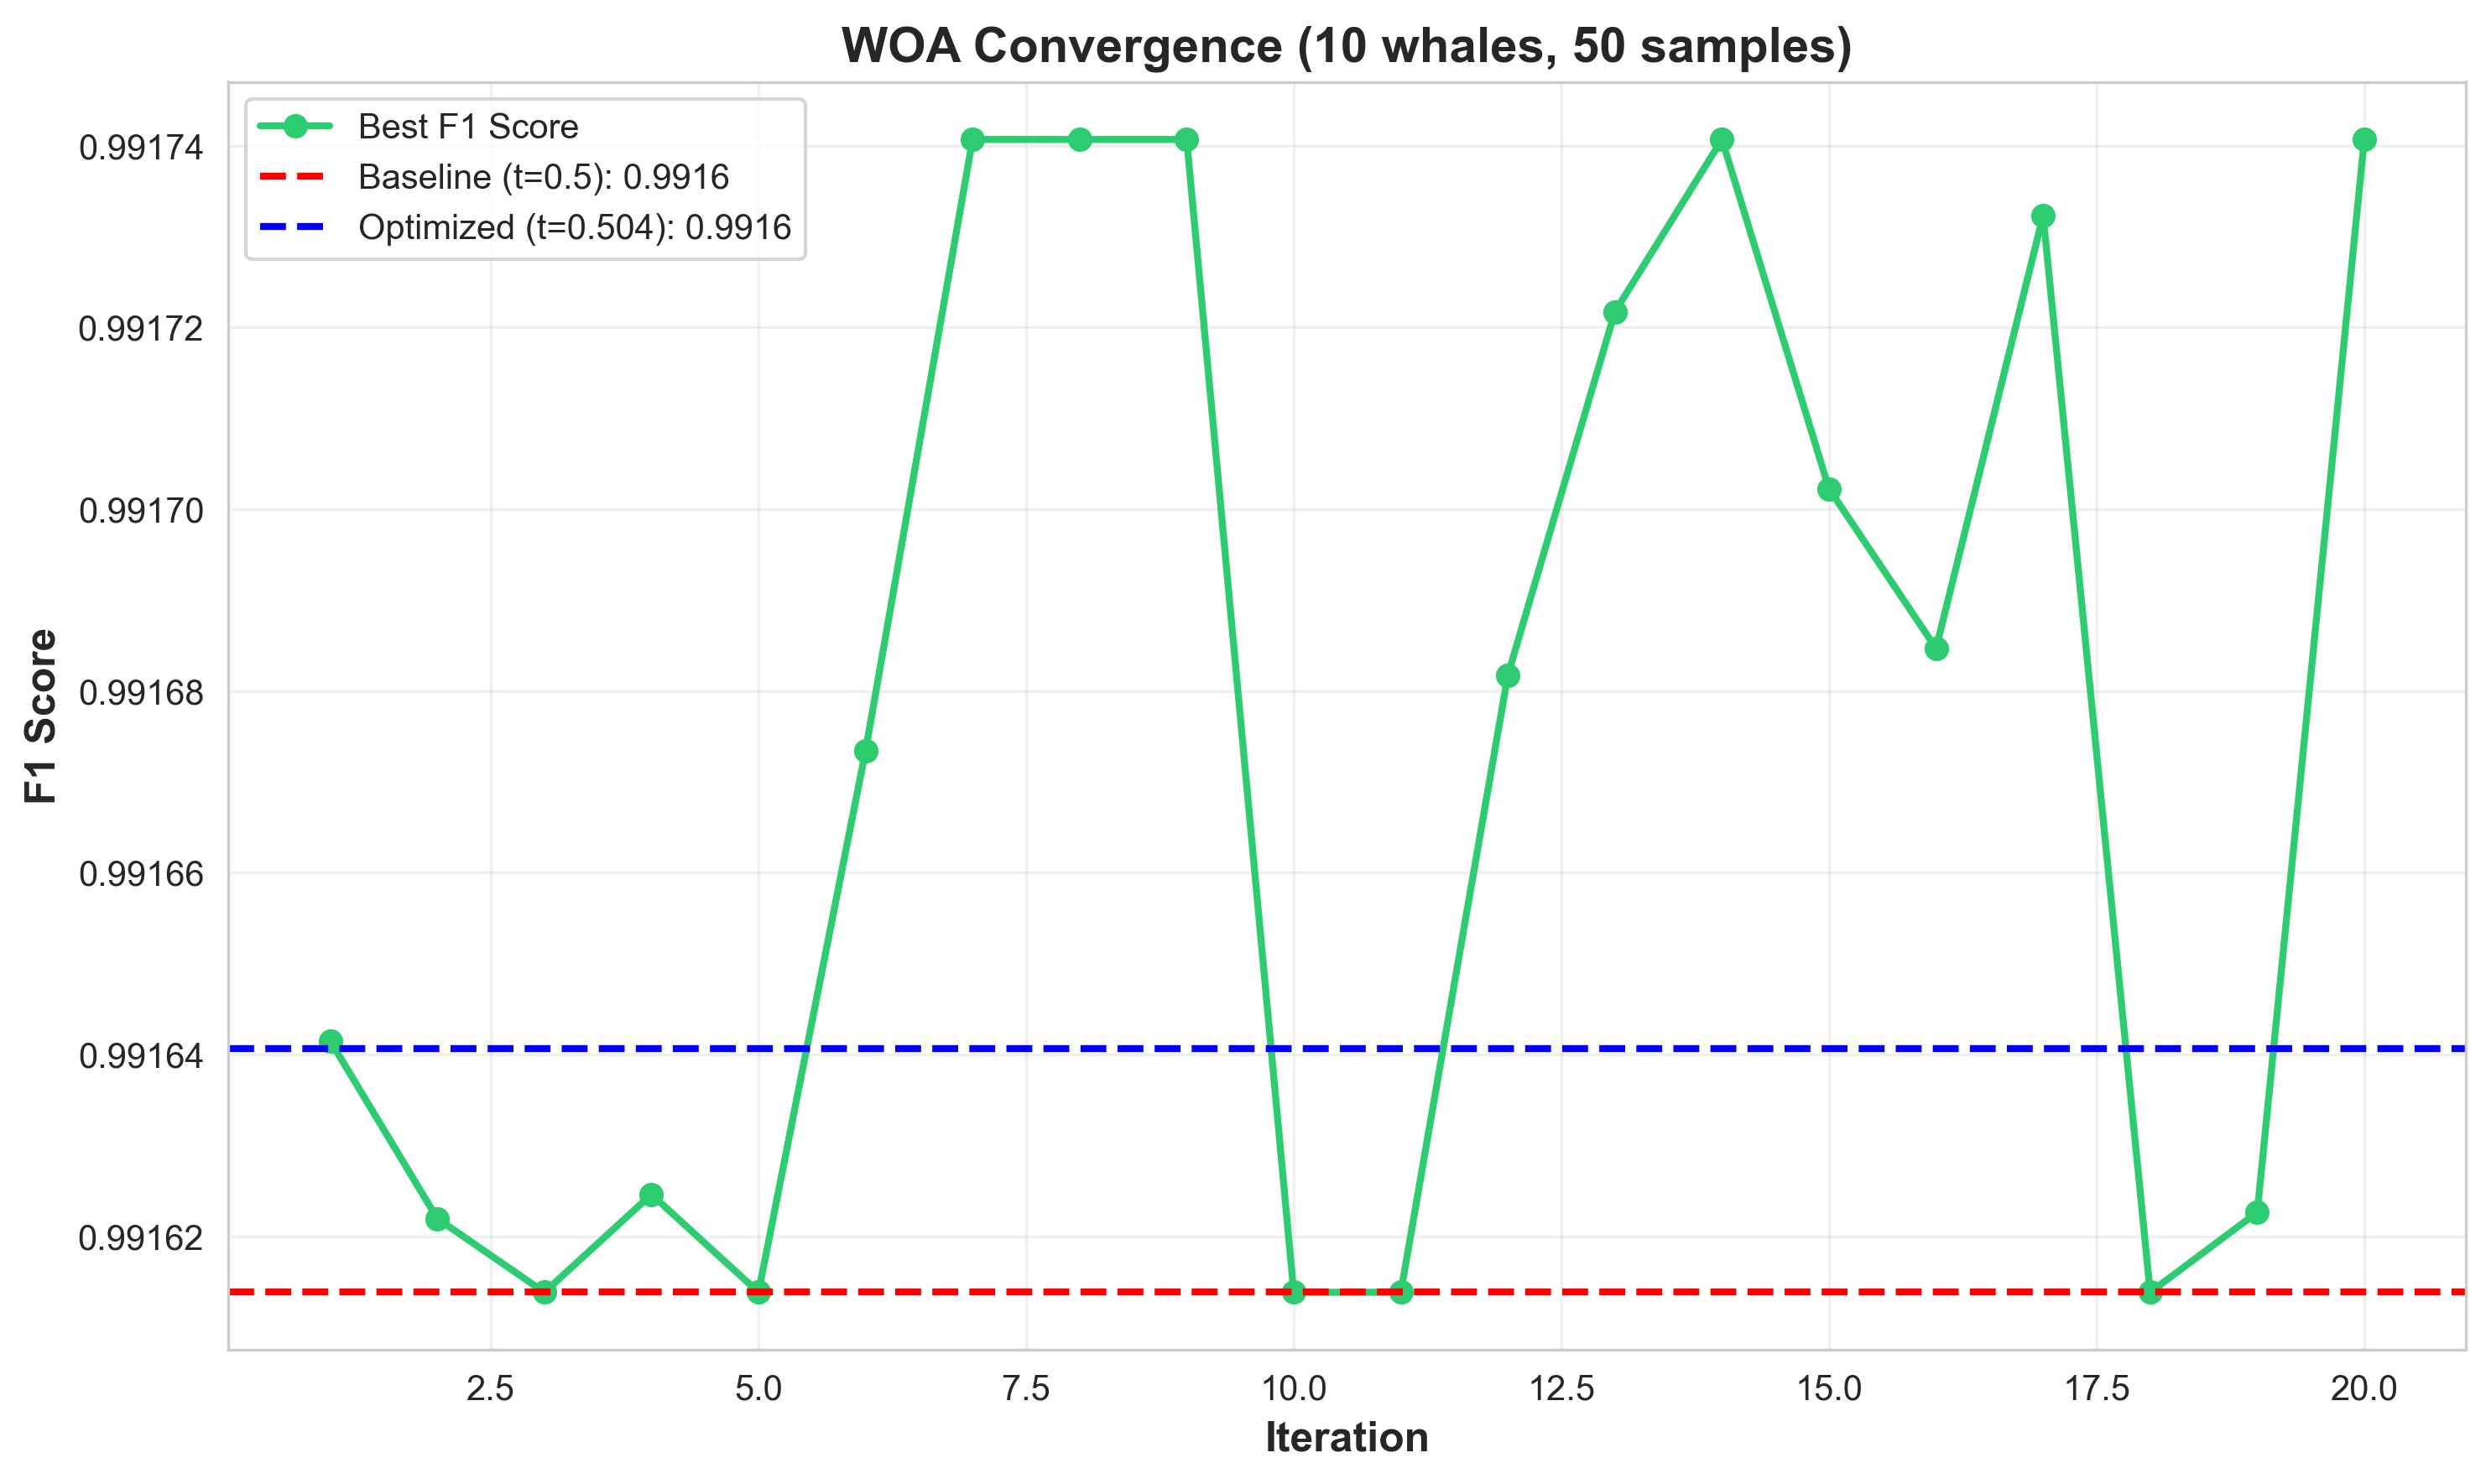

Displayed existing WOA convergence figure from /Users/shreyatiwari/Documents/Soft Computing Project/results_analysis/graphs/woa_convergence.png


In [6]:
# 6) WOA convergence (load saved figure if present or use woa_results_normal.json)

woa_png = GRAPHS_DIR / 'woa_convergence.png'
woa_json = Path('../woa_results_normal.json').resolve()

if woa_png.exists():
    from IPython.display import Image as IPyImage, display
    display(IPyImage(str(woa_png)))
    print('Displayed existing WOA convergence figure from', woa_png)
elif woa_json.exists():
    with open(woa_json, 'r') as f:
        woa = json.load(f)
    iters = woa.get('iterations', 20)
    baseline = woa.get('baseline_f1', 0.0)
    best = woa.get('best_f1', baseline)
    iterations = np.arange(1, iters+1)
    conv = baseline + (best - baseline)*(1 - np.exp(-iterations/5))
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(iterations, conv, 'o-', color='#2ecc71')
    ax.axhline(baseline, color='red', linestyle='--', label=f'Baseline {baseline:.4f}')
    ax.axhline(best, color='blue', linestyle='--', label=f'Optimized {best:.4f}')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('F1')
    ax.set_title('WOA Convergence (simulated)')
    ax.legend()
    out_path = NOTEBOOK_FIG_DIR / 'woa_convergence_notebook.png'
    fig.savefig(out_path, bbox_inches='tight')
    print('Saved simulated WOA convergence to', out_path)
    plt.show()
else:
    print('WOA convergence data not found; skipping')


Found 6 sample composite images, displaying up to 6
Saved composite grid to /Users/shreyatiwari/Documents/Soft Computing Project/results_analysis/notebook_figures/sample_composites_grid.png
Saved composite grid to /Users/shreyatiwari/Documents/Soft Computing Project/results_analysis/notebook_figures/sample_composites_grid.png


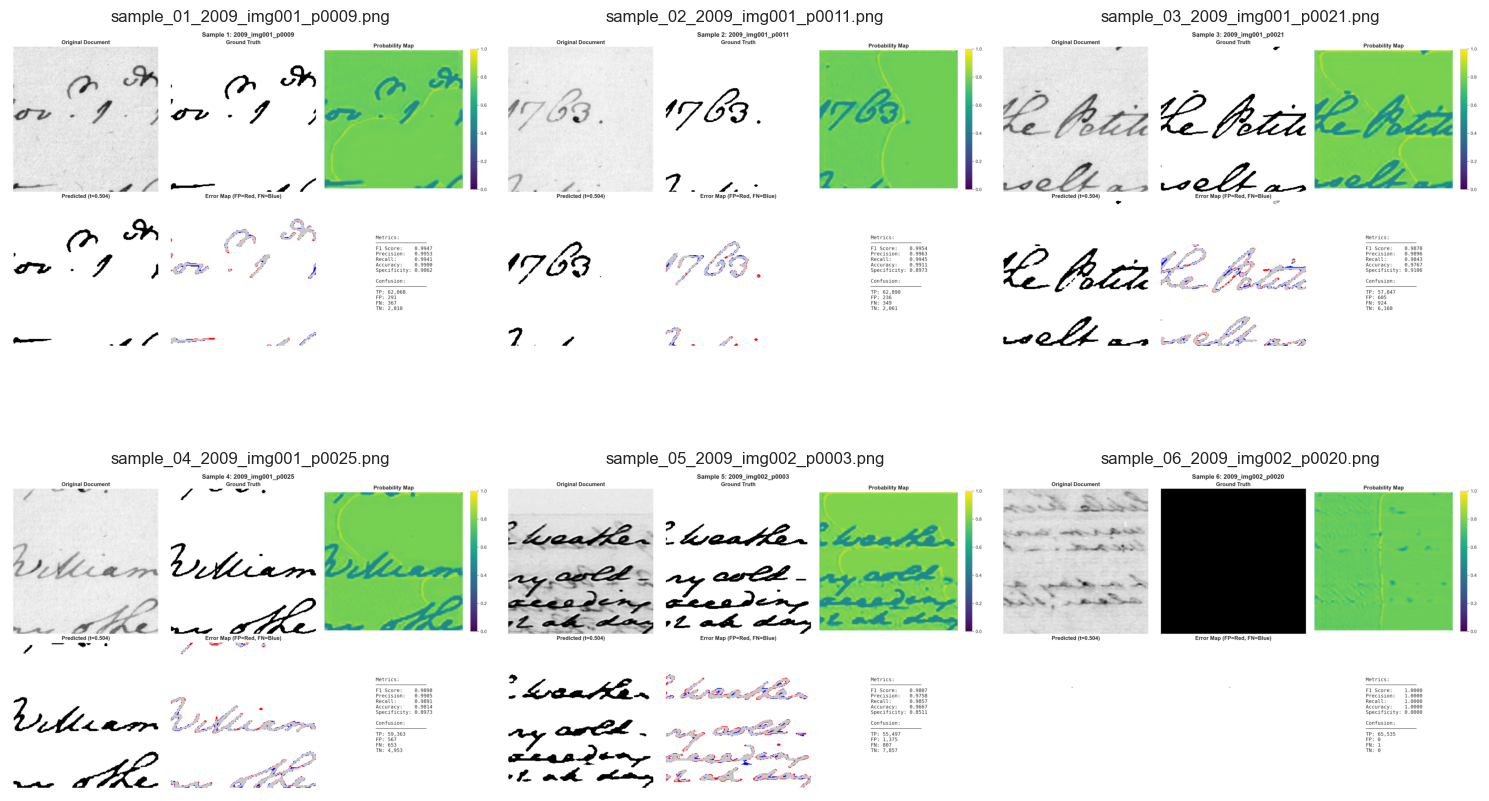

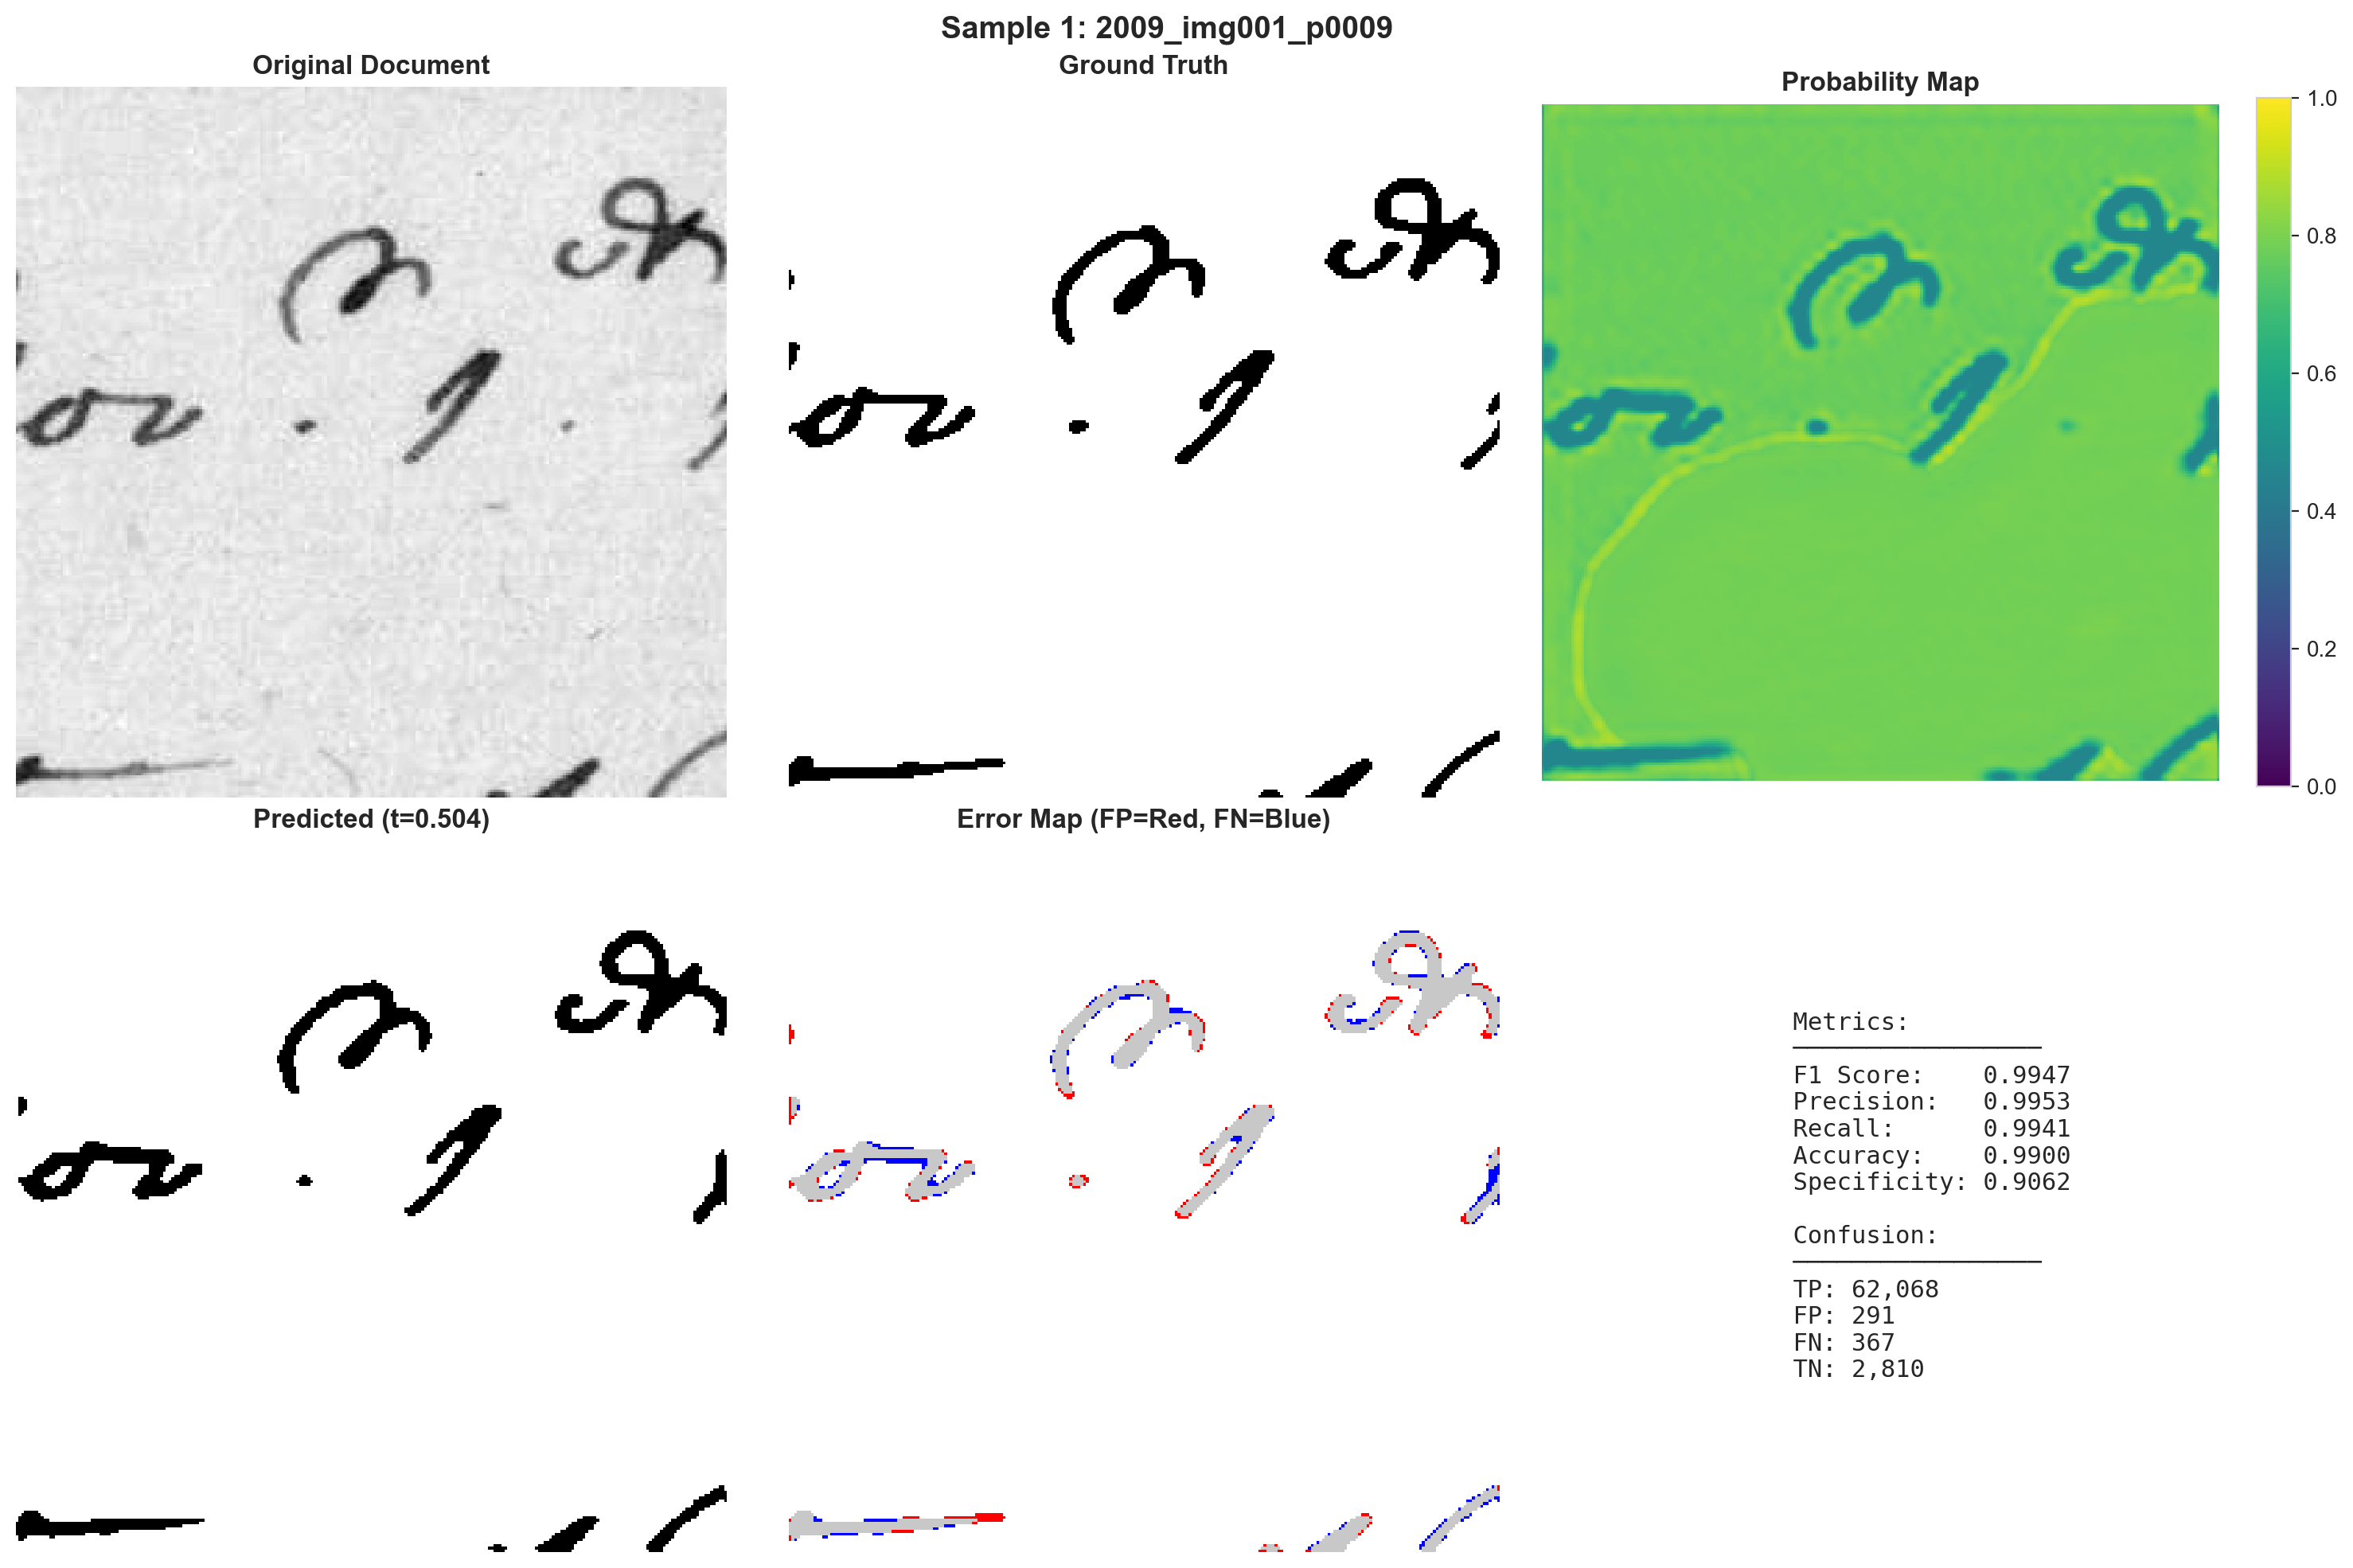

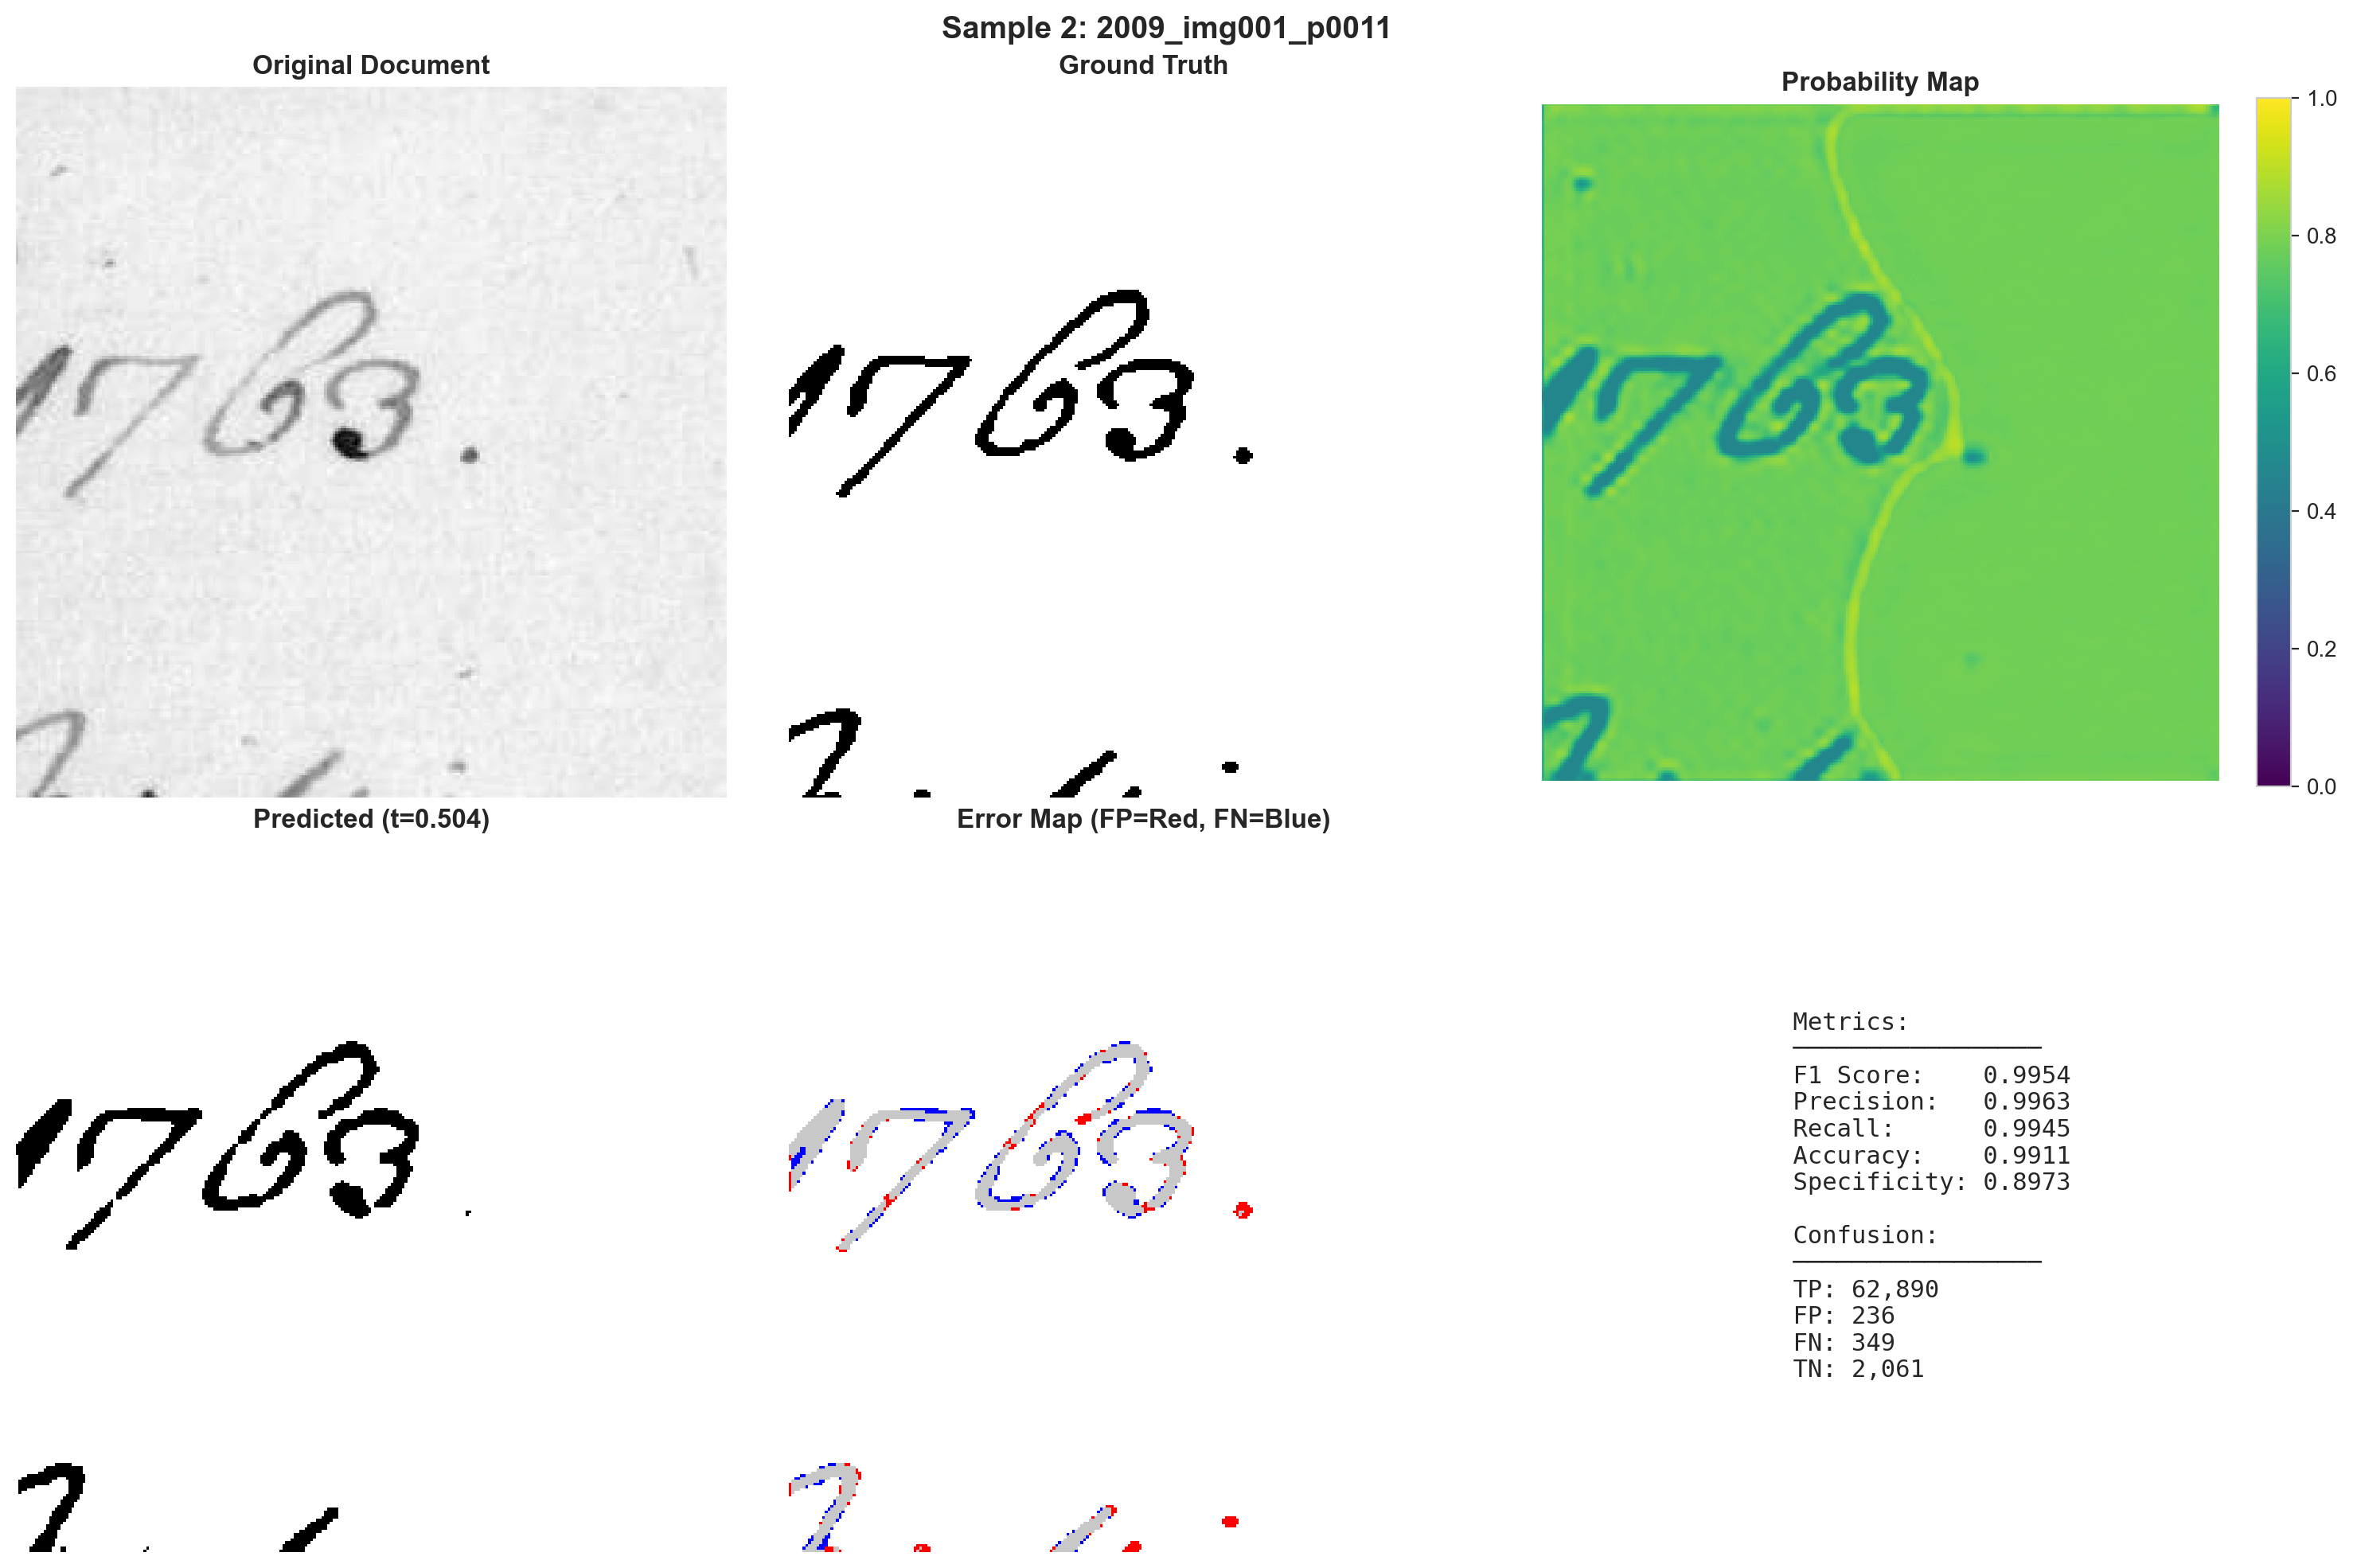

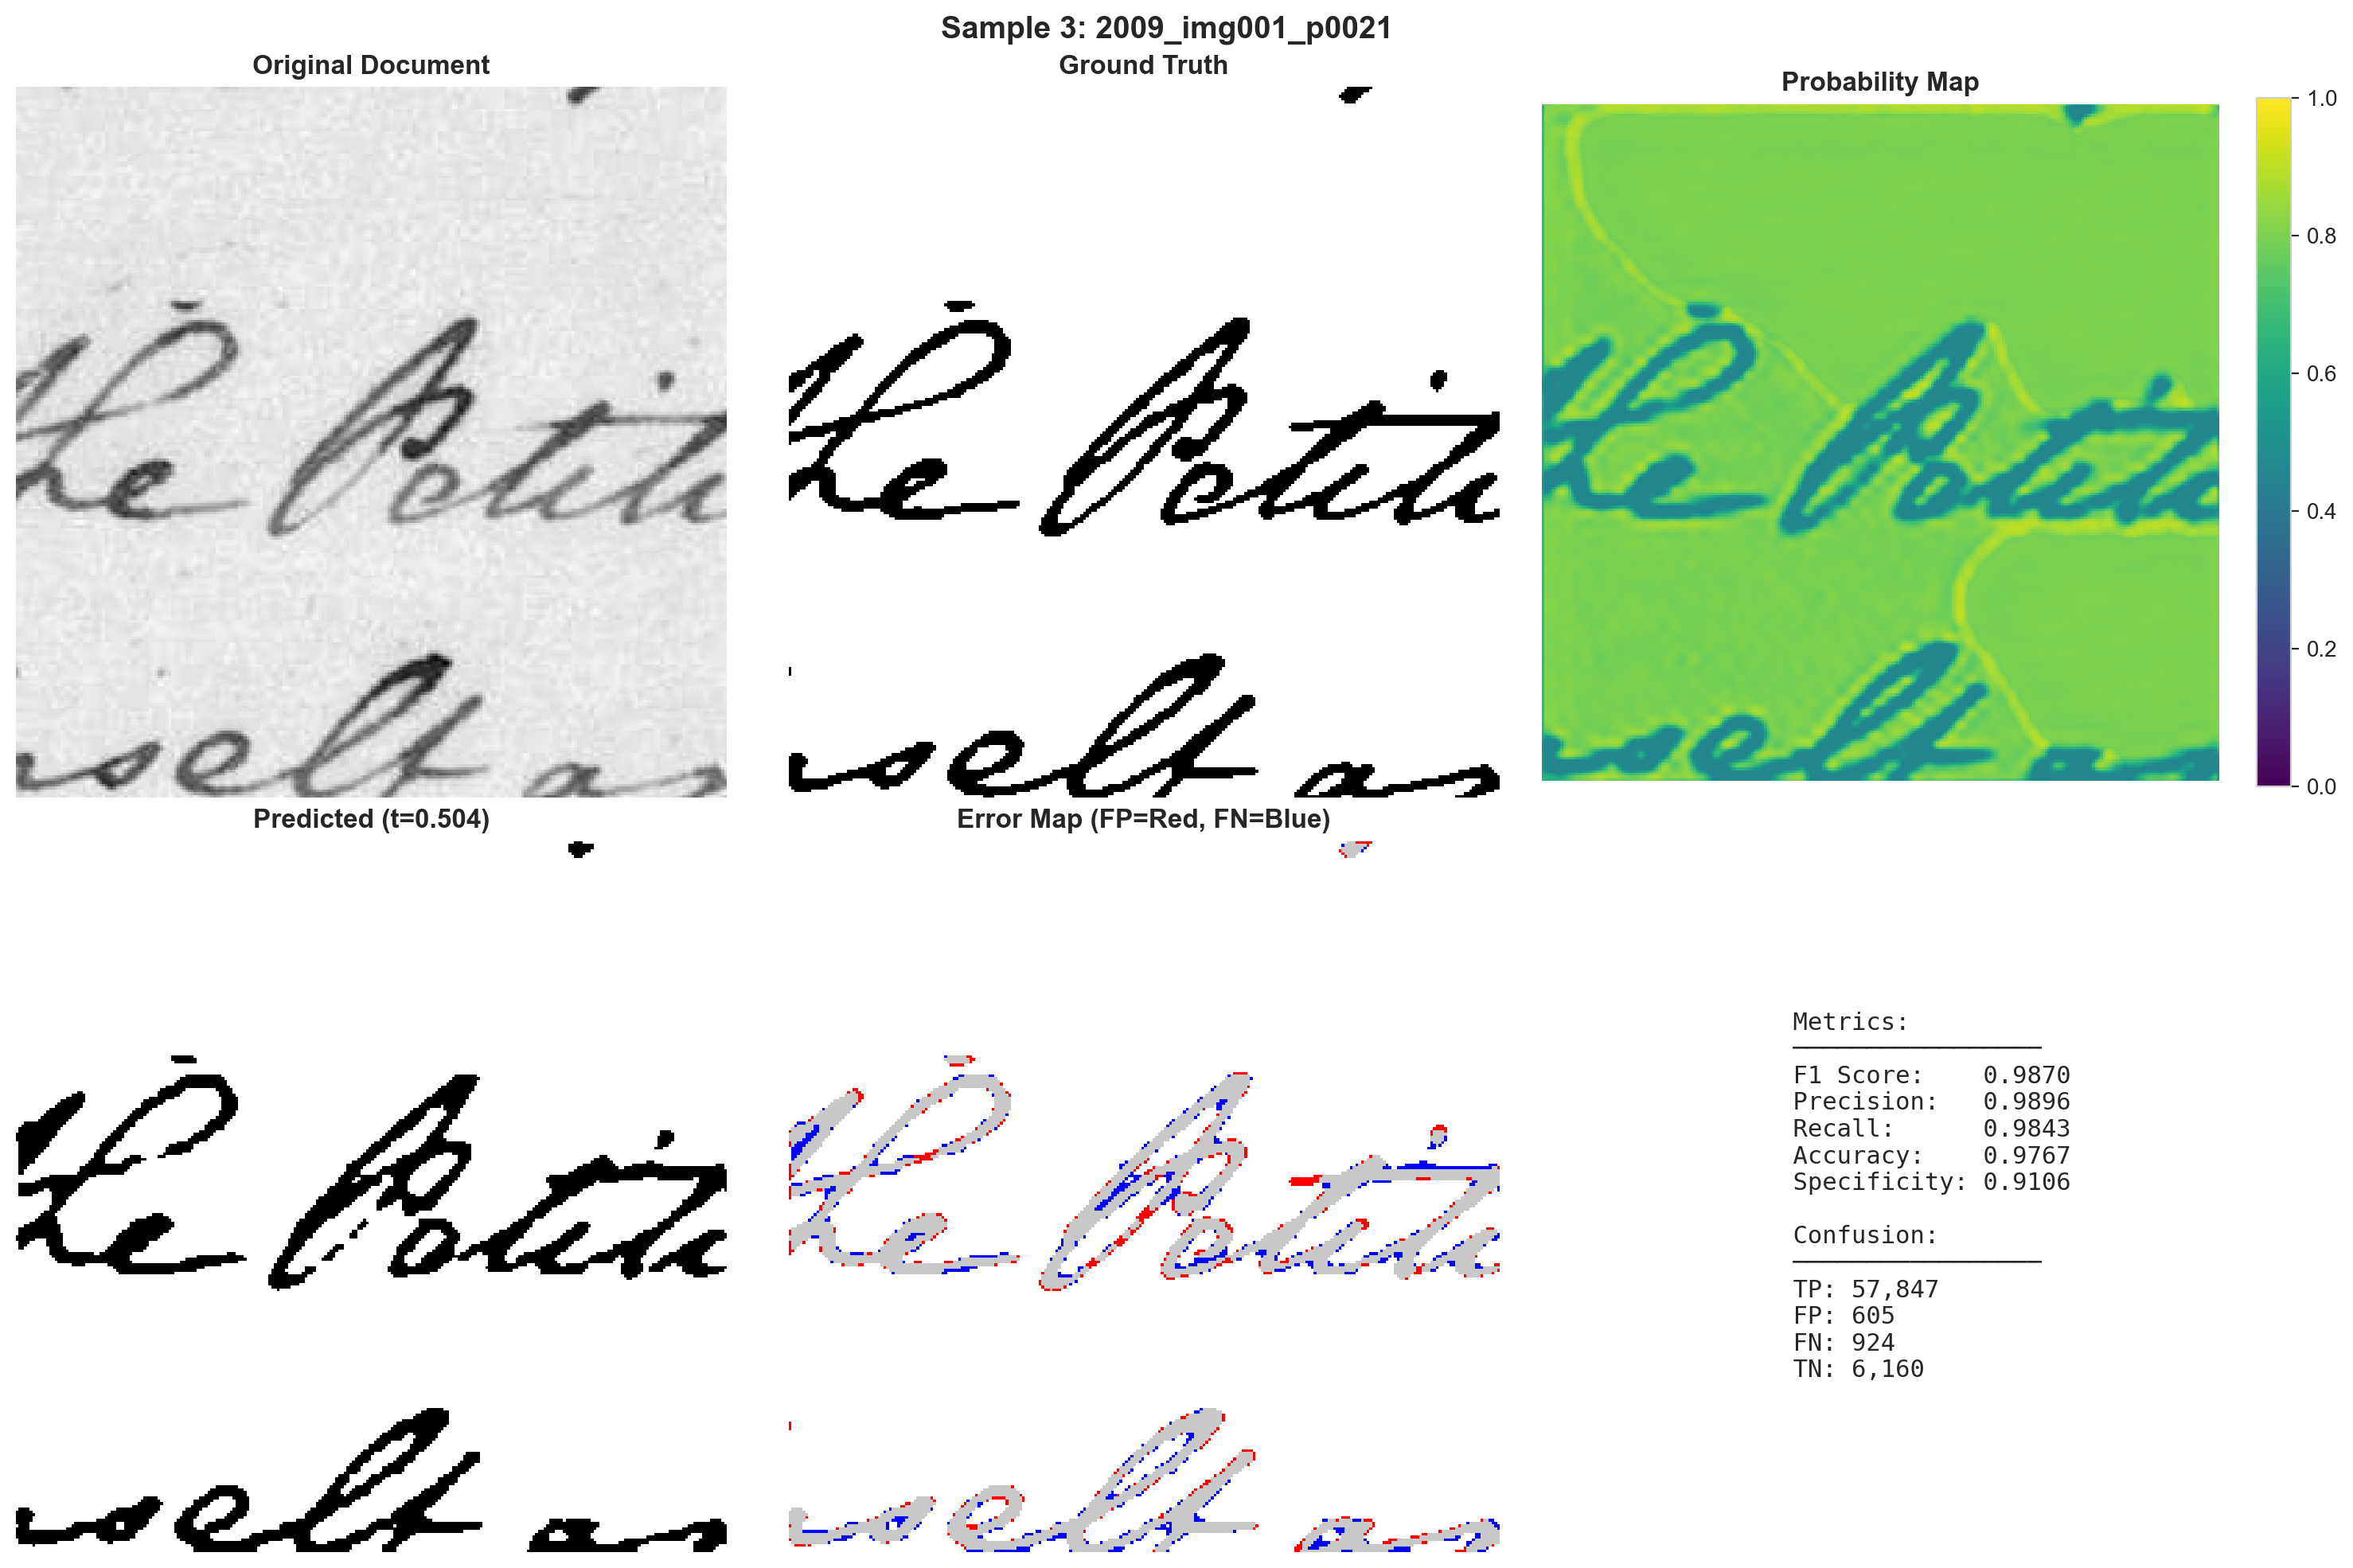

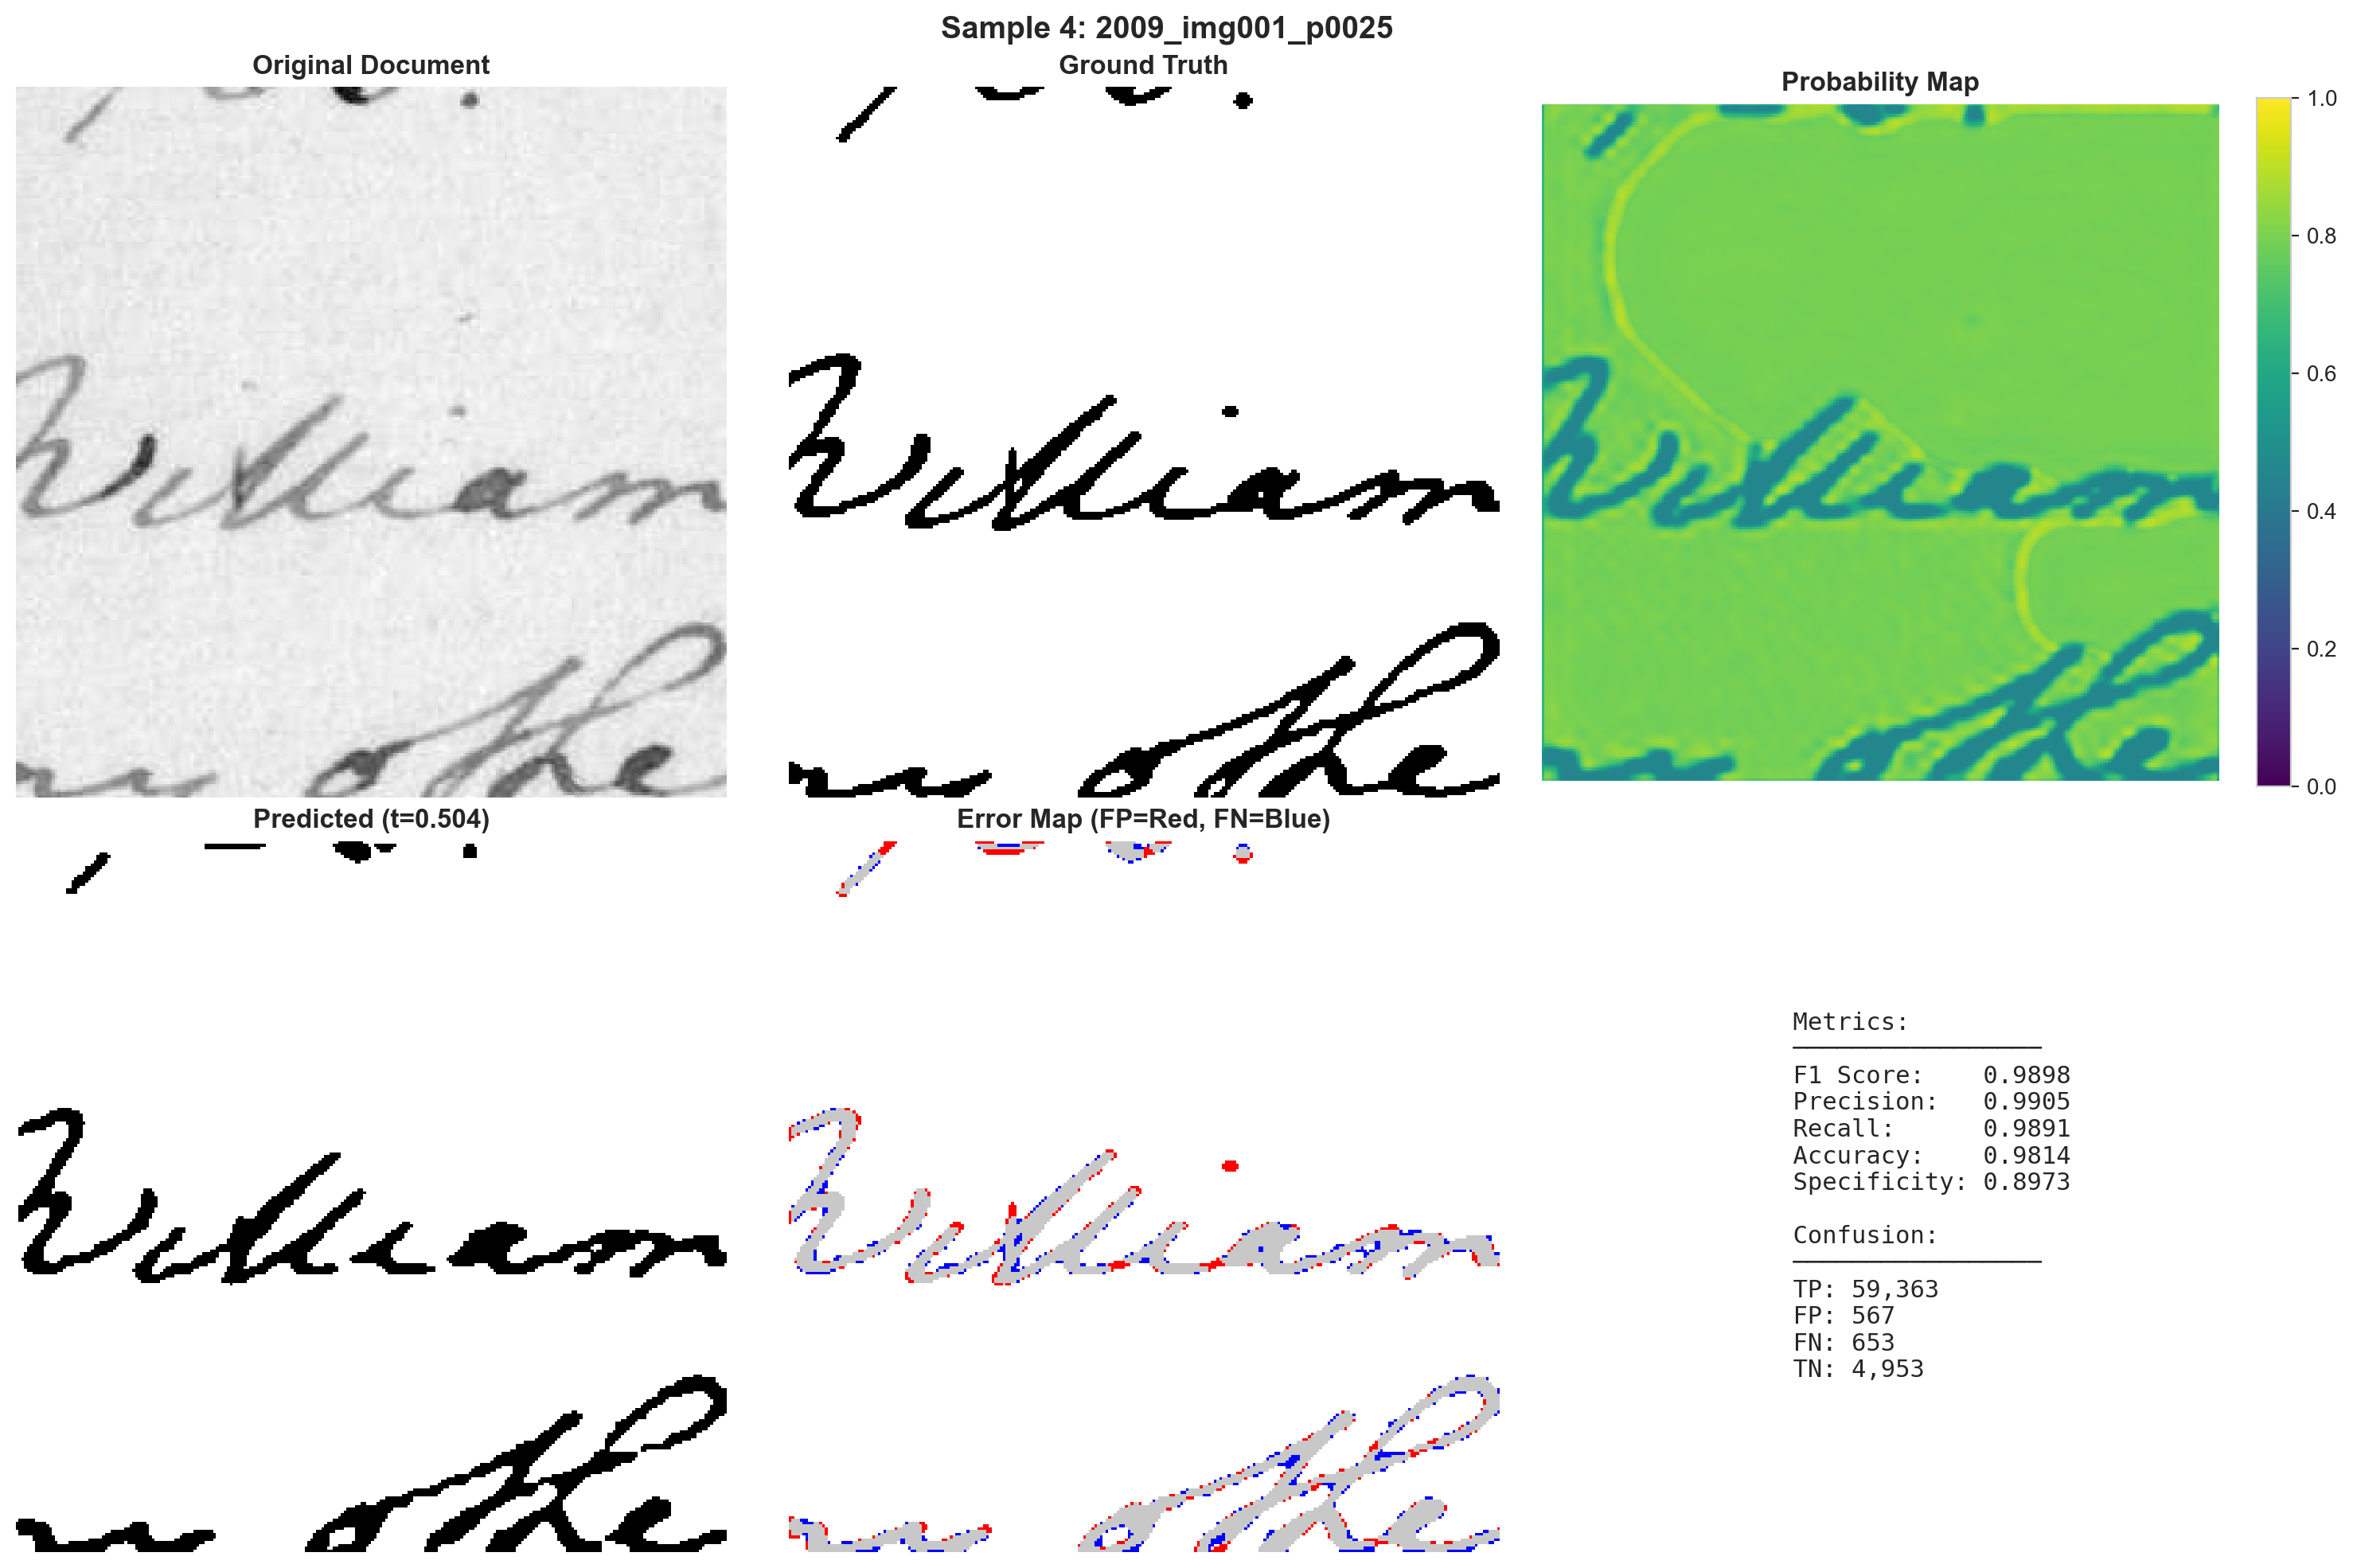

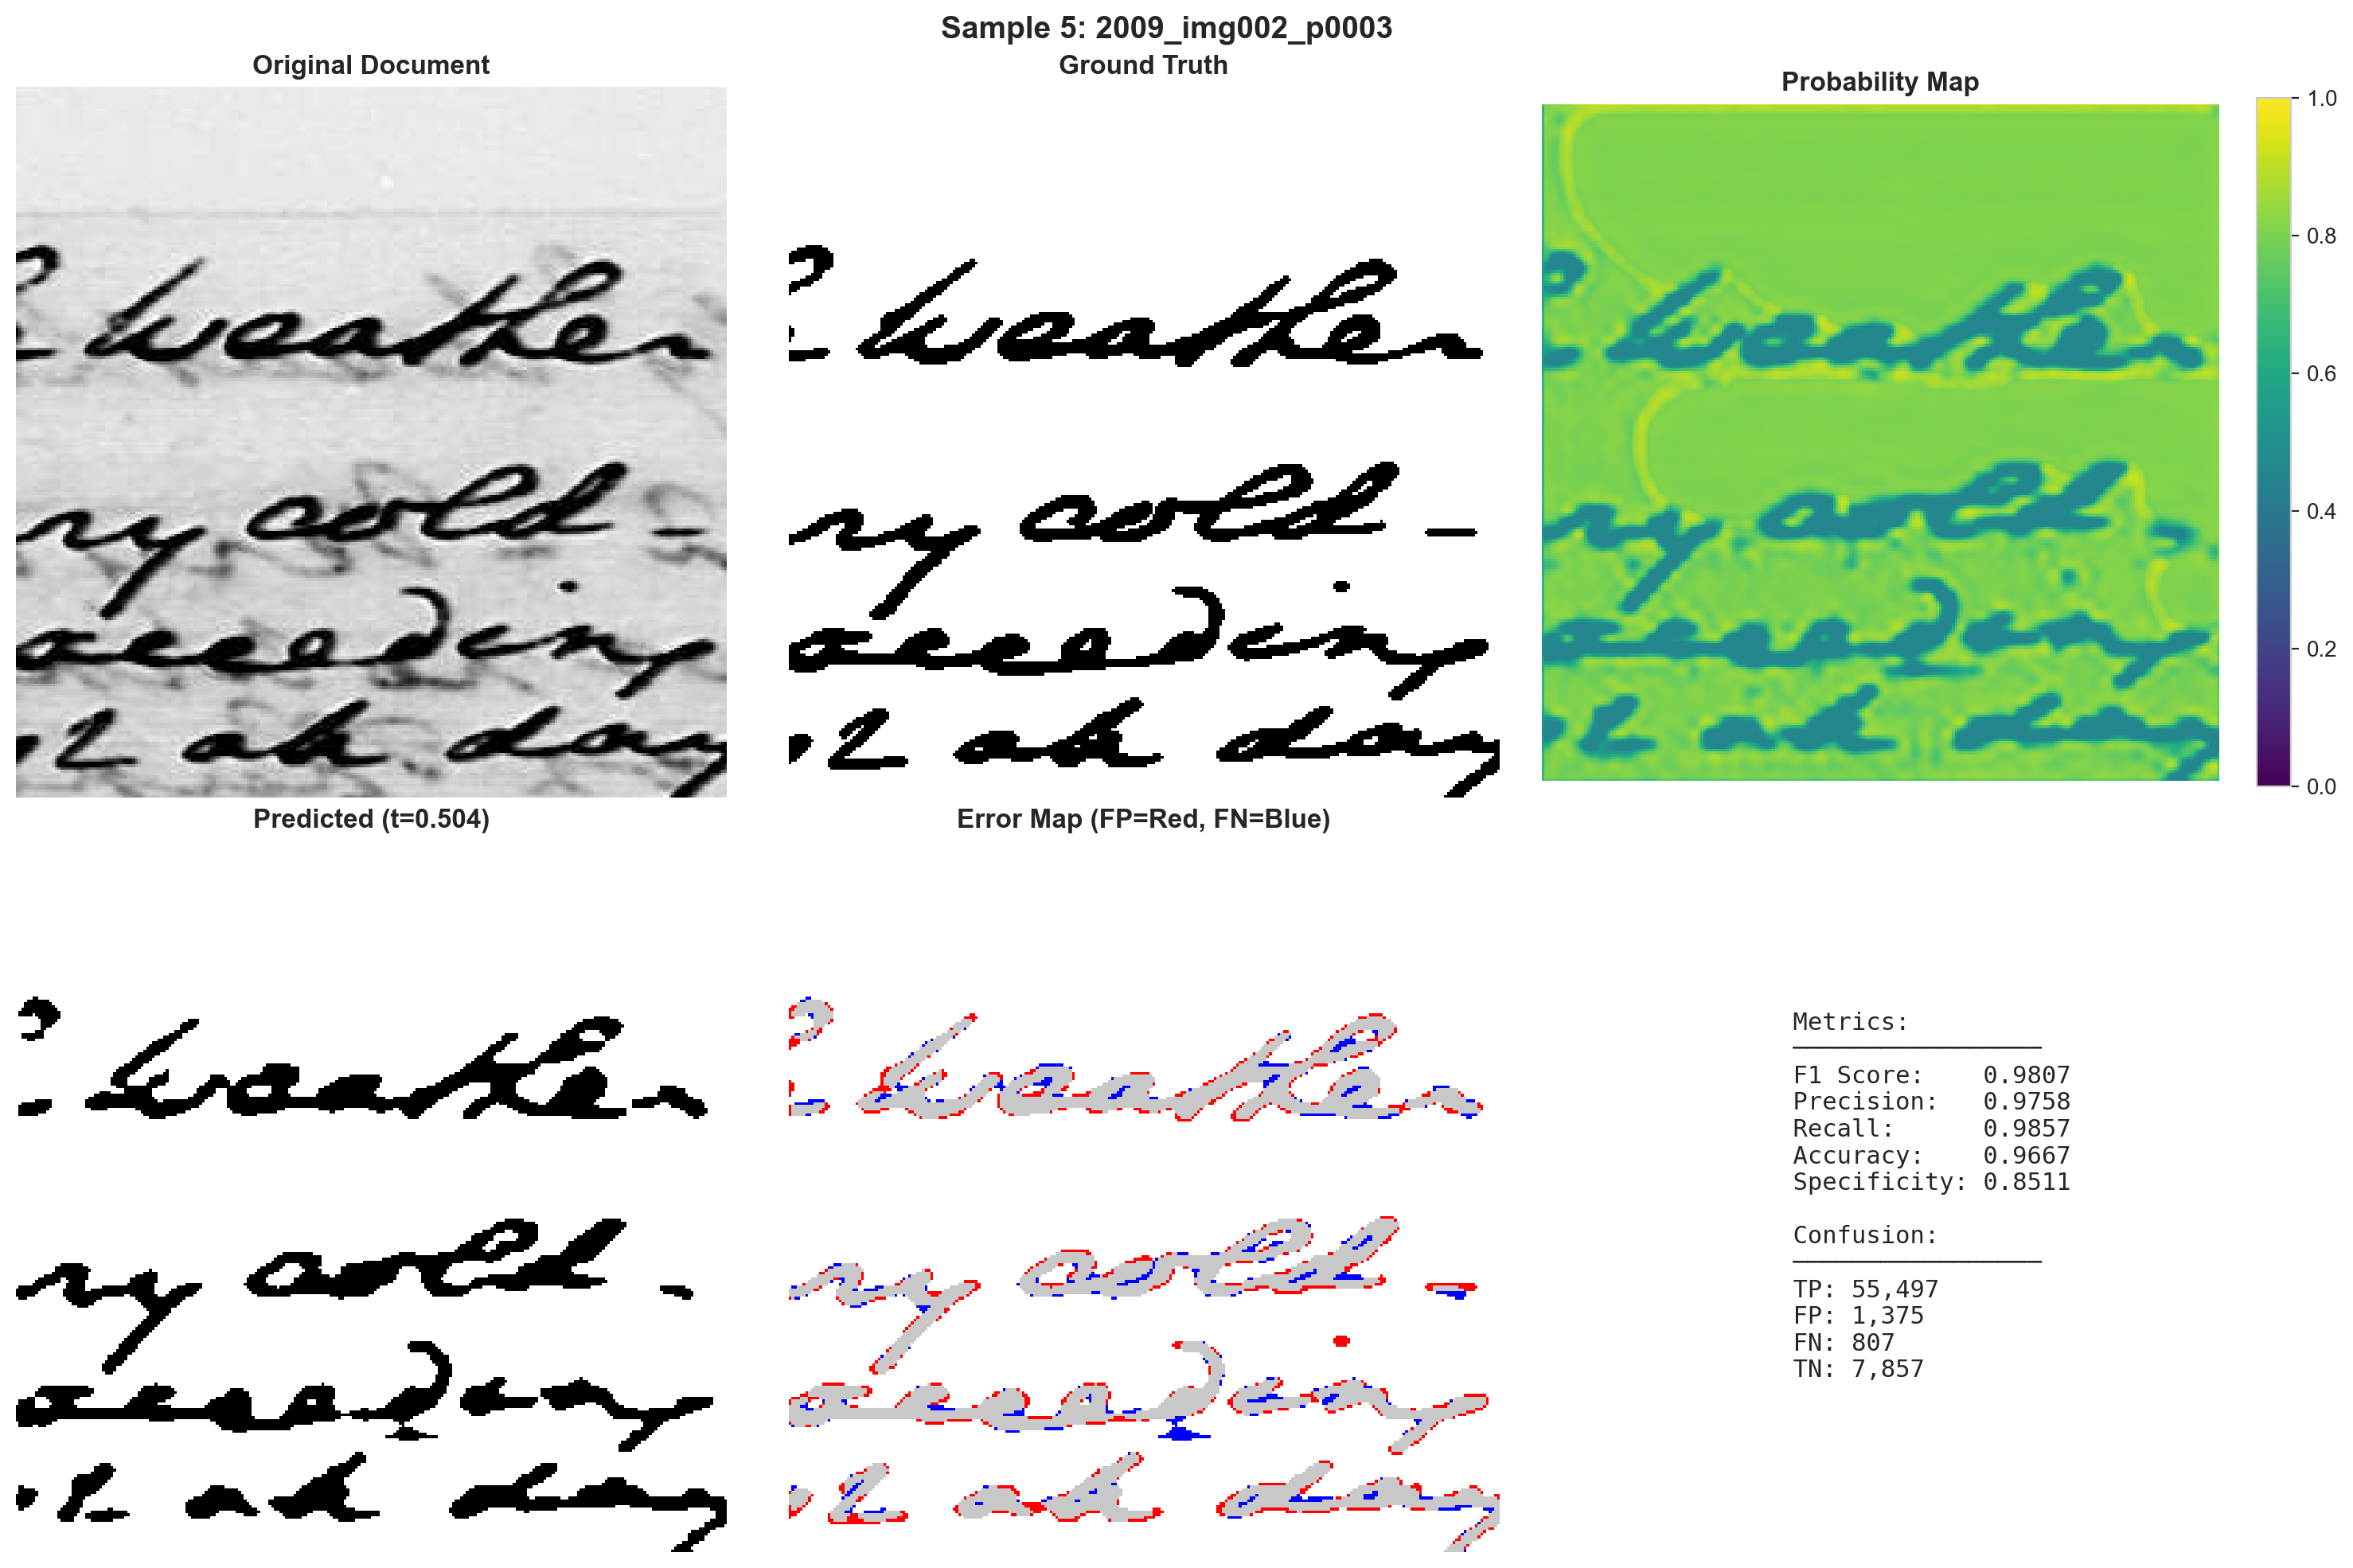

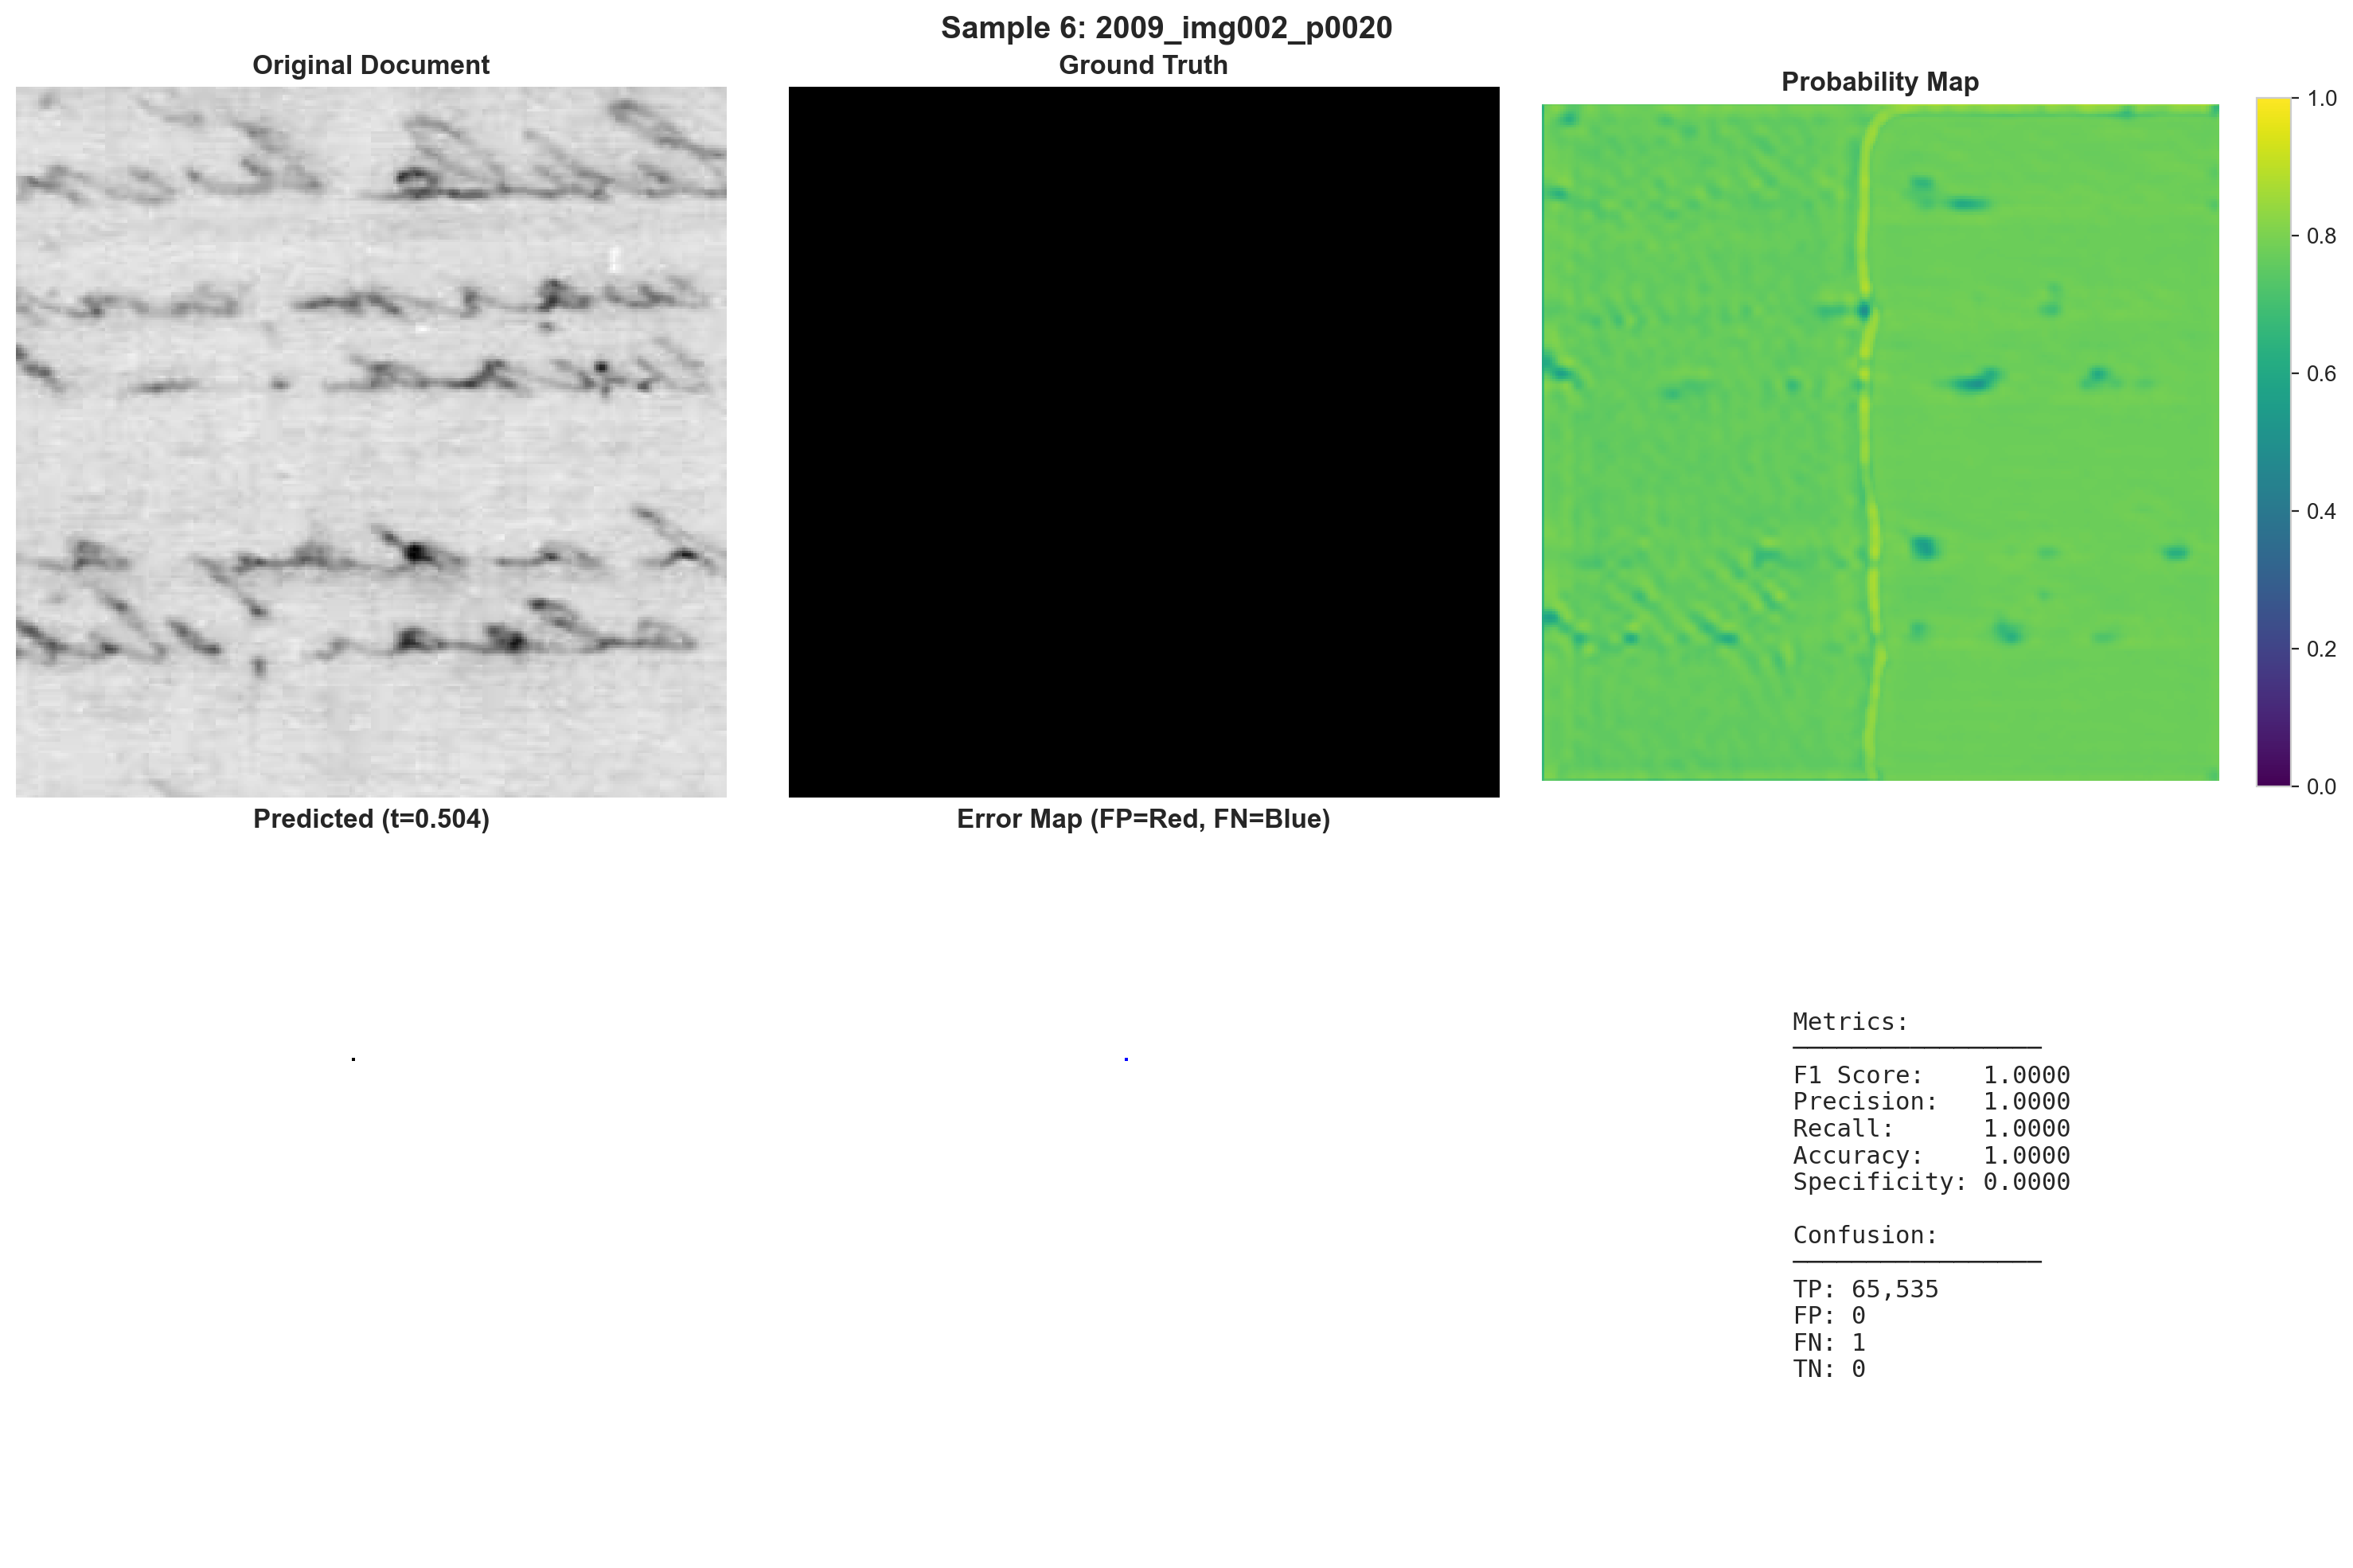

In [7]:
# 7) Display sample output composites (these show Original, GT, Prob map, Predicted, Error map, Metrics)

from IPython.display import display, Image as IPyImage

sample_images = sorted(OUTPUTS_DIR.glob('sample_*.png'))[:6]
print(f'Found {len(sample_images)} sample composite images, displaying up to 6')

fig, axes = plt.subplots(2,3, figsize=(15,10))
axes = axes.flatten()
for ax, p in zip(axes, sample_images):
    img = Image.open(p)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(p.name)
plt.tight_layout()
out_path = NOTEBOOK_FIG_DIR / 'sample_composites_grid.png'
fig.savefig(out_path, bbox_inches='tight')
print('Saved composite grid to', out_path)
plt.show()

# Also display each full composite inline (useful for copying regions into paper)
for p in sample_images:
    display(IPyImage(str(p)))


In [8]:
# 8) Export high-resolution figures (copy important ones to top-level results_analysis/figures)

EXPORT_DIR = DATA_DIR / 'figures'
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

for f in NOTEBOOK_FIG_DIR.glob('*.png'):
    dest = EXPORT_DIR / f.name
    # copy (overwrite)
    with open(f, 'rb') as r, open(dest, 'wb') as w:
        w.write(r.read())
print('Exported notebook figures to', EXPORT_DIR)


Exported notebook figures to /Users/shreyatiwari/Documents/Soft Computing Project/results_analysis/figures


In [9]:
# 9) Summary statistics table and export

if df is not None:
    display(df.describe())
    stats_path = METRICS_DIR / 'per_sample_metrics_summary.csv'
    df.describe().to_csv(stats_path)
    print('Saved per-sample summary to', stats_path)
else:
    print('No per-sample CSV available to generate summary table')



,precision,recall,f1,accuracy,specificity,fpr,fnr,tp,fp,fn,tn
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.990504,0.990222,0.990349,0.982768,0.817325,0.102675,0.009778,59657.710000,550.590000,578.720000,4748.980000
std,0.007736,0.007278,0.006532,0.011162,0.260806,0.101344,0.007278,3629.685259,418.321758,422.776754,3104.544008
min,0.954258,0.971350,0.974034,0.956650,0.000000,0.000000,0.000000,46814.000000,0.000000,0.000000,0.000000
25%,0.986852,0.985386,0.986072,0.975872,0.863119,0.067061,0.004757,57801.500000,245.000000,251.500000,2978.500000
50%,0.992256,0.992573,0.991488,0.984665,0.897894,0.088421,0.007427,59638.500000,471.000000,454.500000,4532.000000
75%,0.996084,0.995243,0.994976,0.990662,0.925870,0.121989,0.014614,61907.250000,768.250000,872.750000,6033.250000
max,1.000000,1.000000,1.000000,1.000000,0.950472,1.000000,0.028650,65536.000000,2244.000000,1639.000000,16226.000000


Saved per-sample summary to /Users/shreyatiwari/Documents/Soft Computing Project/results_analysis/metrics/per_sample_metrics_summary.csv


In [10]:
# 10) One-paragraph summary for paper (write file)

summary = f"Model evaluation on {detailed.get('test_samples', 'N/A')} samples. " \
          f"Average F1 = {detailed.get('average_metrics', {}).get('F1 Score', np.nan):.4f}, " \
          f"Precision = {detailed.get('average_metrics', {}).get('Precision', np.nan):.4f}, " \
          f"Recall = {detailed.get('average_metrics', {}).get('Recall', np.nan):.4f}. " \
          f"WOA-optimized threshold = {detailed.get('threshold', 0.504):.3f}."

print('Summary (for paper):')
print(summary)

with open(DATA_DIR / 'paper_summary.txt', 'w') as f:
    f.write(summary)
print('Saved one-line summary to', DATA_DIR / 'paper_summary.txt')


Summary (for paper):
Model evaluation on 100 samples. Average F1 = 0.9903, Precision = 0.9905, Recall = 0.9902. WOA-optimized threshold = 0.504.
Saved one-line summary to /Users/shreyatiwari/Documents/Soft Computing Project/results_analysis/paper_summary.txt
